## Using Deep Learning Binary Classification to Inspect z = 6-8 Galaxies from JWST CEERS

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from astropy.table import Table
from PIL import Image  # displaying images
import cv2             # .pngs into np array
import glob
import time

import tensorflow as tf
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import random_zoom  # image augmentation
from sklearnex import patch_sklearn    # scikit-learn patch for Windows
patch_sklearn()
from sklearn import manifold, datasets
from sklearn.model_selection import train_test_split as TTS

import matplotlib.pyplot as plt
plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Gathering raw image data and source IDs

In [2]:
relative_directory = '../single_filter_pngs'
filenames = glob.glob(f'{relative_directory}/*w.png')
raw_images = np.array([cv2.imread(i) for i in filenames])
print('raw image dimensions:',raw_images[0].shape)

raw image dimensions: (51, 51, 3)


In [3]:
IDs = []
# script only for local single-filter image filenames
for i in filenames:
    i = i[22:]              # removing directory string
    index = i.index('_')
    ID = i[:index]          # indexing ID string
    IDs.append(ID)

ID: 11325


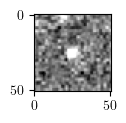

ID: 113


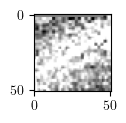

In [4]:
for i in range(56,58):
    print('ID:',IDs[i])
    plt.figure(figsize=(1,1))
    plt.imshow(raw_images[i])
    plt.show()

### Preprocessing image data
* **normalized images for neural network to converge faster**
* **This scales the pixel values to be between 0 and 1**
  * **standard pixel values are between 0 and 255**

In [5]:
preprocessed_images = normalize(raw_images, axis=1)
print('preprocessed image dimensions:', preprocessed_images[0].shape)

preprocessed image dimensions: (51, 51, 3)


ID: 11325


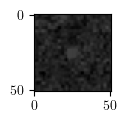

ID: 113


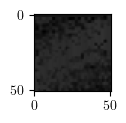

In [6]:
for i in range(56,58):
    print('ID:',IDs[i])
    plt.figure(figsize=(1,1))
    plt.imshow(preprocessed_images[i])
    plt.show()

### Gathering labels and stats of dataset
* **keeping all corresponding lists in the same order as local files**

In [7]:
# excel file with IDs + labels + reasons for all 1816 sources
xlsx_df = pd.read_excel('../Inspections/z = 6-8 Inspection Labels.xlsx')

labels = []
reasons = []
# collect in order of IDs list
for i in IDs:
    xlsx_row = list(xlsx_df['Source_ID']).index(int(i))
    labels.append(xlsx_df['Reliable_Source'][xlsx_row])
    reasons.append(xlsx_df['Reason'][xlsx_row])
    
# creating DataFrame
T = Table()
T['source_id'] = IDs
T['label'] = labels
T['reason'] = reasons
df = pd.DataFrame(np.array(T))
    
print('out of '+str(len(IDs)) + ' sources, ' + str(labels.count(0))+' spurious sources (' + str(round((labels.count(0) / (len(IDs)))*100)) + '%)\n')
print('diffraction spikes:       '+str(reasons.count('diffraction spike'))+'\n'+'edge of data:             '+str(reasons.count('edge data'))+'\n'+'close to another source:  '+str(reasons.count('close to another source')))

out of 1816 sources, 57 spurious sources (3%)

diffraction spikes:       29
edge of data:             7
close to another source:  21


### Data cut
* **The focus of this CNN is to learn how to differentiate between a good source and diffraction spike sources**
  * **Removed other types of spurious sources from dataset**

In [8]:
# data cut
cut = np.where((T['label'] == 1) | (T['reason'] == 'diffraction spike'))[0]
dataset = T[cut]
IDs_dataset = list(dataset['source_id'])
labels_dataset = list(dataset['label'])

# saving new images and diffraction images for later
new_images = []
diff_images = []
diff_IDs = []
for i in range(len(preprocessed_images)):
    if (labels[i] == 1) or (reasons[i] == 'diffraction spike'):
        new_images.append(preprocessed_images[i])
    if (labels[i] == 0) and (reasons[i] == 'diffraction spike'):
        diff_images.append(preprocessed_images[i])
        diff_IDs.append(IDs[i])
        
print('out of '+str(len(IDs_dataset)) + ' sources, ' + str(labels_dataset.count(0))+' diffraction spike spurious sources (' + str(round((labels_dataset.count(0) / (len(IDs_dataset)))*100)) + '%)\n')

out of 1788 sources, 29 diffraction spike spurious sources (2%)



### Augmentation of spurious classification
* **Need to mitigate the impact of class imbalance**
  * **Added rotated diffraction spikes to dataset**
  * **Added a higher weight to these spurious sources**

In [9]:
# --------------DO NOT RUN CELL MORE THAN ONCE-------------------
# 'k' denotes the number of 90 degree anticlockwise rotations
rotated1 = tf.image.rot90(diff_images, k=1) # 90 degree rotation
rotated2 = tf.image.rot90(diff_images, k=2) # 180 degree rotation
rotated3 = tf.image.rot90(diff_images, k=3) # 270 degree rotation
rotated = tf.concat([rotated1, rotated2, rotated3], axis=0)

# adding augmented images to dataset with duplicates
image_dataset = new_images + list(rotated)*6
# adjusting other lists
for i in range(18):
    for j in range(29):
        # augmented state 1-3 are rotated
        IDs_dataset.append(str(diff_IDs[j]) + ', augmented state: ' + str(i+1))
        labels_dataset.append(0)

In [10]:
print('out of '+str(len(IDs_dataset)) + ' sources, ' + str(labels_dataset.count(0))+' diffraction spike spurious sources (' + str(round((labels_dataset.count(0) / (len(IDs_dataset)))*100)) + '%)\n')

out of 2310 sources, 551 diffraction spike spurious sources (24%)



In [11]:
# adding a higher weight to spurious sources
class_weights = {0: 20.0, 1: 1.0}

ID: 123
label: 0


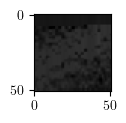

ID: 123, augmented state: 1
label: 0


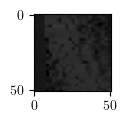

In [23]:
for i in range(1,2):
    print('ID:',diff_IDs[i])
    print('label: 0')
    plt.figure(figsize=(1,1))
    plt.imshow(diff_images[i])
    plt.show()

for i in range(1789,1790):
    print('ID:',IDs_dataset[i])
    print('label:',labels_dataset[i])
    plt.figure(figsize=(1,1))
    plt.imshow(image_dataset[i])
    plt.show()

### Splitting dataset

In [13]:
X = np.array(image_dataset)   # features
y = np.array(labels_dataset)  # labels

X_train,X_valid,y_train,y_valid = TTS(X,y,train_size=0.7,test_size=0.3,random_state=0)
print(len(X_train),'in training set and',len(X_valid),'in testing set')

1617 in training set and 693 in testing set


### Building a deep learning model

In [14]:
model = Sequential([
        # 1st convolution
        Conv2D(32,(3,3),activation='relu',input_shape=(51,51,3)),
        MaxPooling2D(pool_size=(2,2)),
        # 2nd convolution
        Conv2D(32,(3,3),1,activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        # 3rd convolution
        Conv2D(64,(3,3),1,activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        # flatten before running through DNN
        Flatten(),
        # 64 neuron hidden layer
        Dense(64, activation='relu'),
        # dropout is a method of reducing overfitting
        # turns off random neurons to prevent coadaptation of the outputs
        Dropout(0.5),
        # 1 output neuron. It will contain a value from 0-1 where 0 for 'spurious source' and 1 for 'good source'
        Dense(1, activation='sigmoid') 
])

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 49, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

### Train the model

In [16]:
history = model.fit(X_train, y_train, class_weight=class_weights, epochs=20, batch_size=32,validation_data=(X_valid,y_valid))

Epoch 1/20
51/51 [==============================] - 5s 76ms/step - loss: 2.4362 - accuracy: 0.2430 - val_loss: 1.6959 - val_accuracy: 0.2439
Epoch 2/20
51/51 [==============================] - 3s 67ms/step - loss: 2.2369 - accuracy: 0.2362 - val_loss: 1.0387 - val_accuracy: 0.2439
Epoch 3/20
51/51 [==============================] - 4s 70ms/step - loss: 1.8341 - accuracy: 0.3253 - val_loss: 0.7036 - val_accuracy: 0.5902
Epoch 4/20
51/51 [==============================] - 3s 61ms/step - loss: 1.1108 - accuracy: 0.7019 - val_loss: 0.7016 - val_accuracy: 0.7244
Epoch 5/20
51/51 [==============================] - 4s 69ms/step - loss: 0.8682 - accuracy: 0.8027 - val_loss: 0.2623 - val_accuracy: 0.9235
Epoch 6/20
51/51 [==============================] - 4s 69ms/step - loss: 0.8061 - accuracy: 0.8380 - val_loss: 0.5177 - val_accuracy: 0.8369
Epoch 7/20
51/51 [==============================] - 4s 70ms/step - loss: 0.6830 - accuracy: 0.8578 - val_loss: 0.1525 - val_accuracy: 0.9452
Epoch 8/20
51

### Plot performance

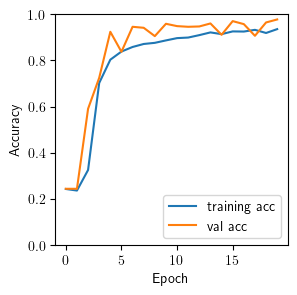

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(3,3))
plt.plot(acc, label='training acc')
plt.plot(val_acc, label = 'val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

### Evaluating the model on training data

In [18]:
scores = model.evaluate(X_train,y_train)
print('\n%s: %.2f%%' % (model.metrics_names[1],scores[1]*100))

51/51 [==============================] - 0s 5ms/step - loss: 0.0902 - accuracy: 0.9716

accuracy: 97.16%


### Evaluating the model on validation data

In [19]:
scores = model.evaluate(X_valid,y_valid)
print('\n%s: %.2f%%' % (model.metrics_names[1],scores[1]*100))

22/22 [==============================] - 0s 5ms/step - loss: 0.0858 - accuracy: 0.9769

accuracy: 97.69%


### Inspecting predictions

In [20]:
predictions = model.predict([X_valid])

22/22 [==============================] - 0s 5ms/step


Label: 0
Prediction: [0.04782183]


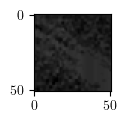

Label: 1
Prediction: [0.99902767]


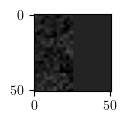

Label: 0
Prediction: [0.00622867]


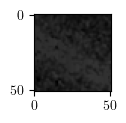

Label: 1
Prediction: [1.]


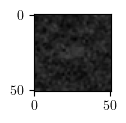

Label: 0
Prediction: [0.02796627]


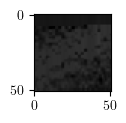

Label: 1
Prediction: [0.9999911]


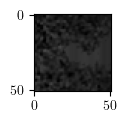

Label: 1
Prediction: [0.99999887]


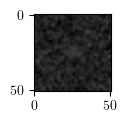

Label: 0
Prediction: [0.00294908]


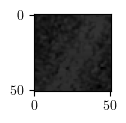

Label: 1
Prediction: [1.]


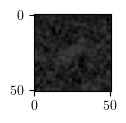

Label: 0
Prediction: [0.07921957]


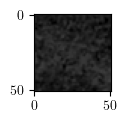

In [22]:
for i in range(50,60):
    print('Label:',y_valid[i])
    print('Prediction:',predictions[i])
    plt.figure(figsize=(1,1))
    plt.imshow(X_valid[i])
    plt.show()